# Missing data imputation


- `per_dem` & `per_voted` - drop `Alaska` - the state is very unique and has only 29 counties, therefore, this data are dropped
- `SVI` , `SVI_cat` & `SES` - only one county has a missing value - impute using the mean value for the state of New Mexico, where the county is
- `cases_prop`, `death_prop` & `PrematureDeath` - use RFR to predict these two features from other features with which they are correlated  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import spearmanr
#from sklearn.model_selection import train_test_split

In [2]:
base = os.path.split(os.getcwd())[0]
dd = base + '/data/'

In [3]:
df = pd.read_csv(dd + 'data_after_final_EDA.csv')

In [4]:
df.columns

Index(['fips', 'state', 'county', 'state_abb', 'pop_full_12plus_per',
       'pop_full_18plus_per', 'pop_full_65plus_per', 'cases_prop',
       'death_prop', 'hesitant_unsure', 'hesitant_strongly', 'SVI', 'SVI_cat',
       'CVAC', 'CVAC_cat', 'Hispanic (%)',
       'non-Hispanic American Indian/Alaska Native (%)',
       'non-Hispanic Asian (%)', 'non-Hispanic Black (%)',
       'non-Hispanic Native Hawaiian/Pacific Islander (%)',
       'non-Hispanic White (%)', 'noHealthInsurance', 'noHighSchool',
       'Poverty', 'SES', 'WBSeg', 'WNWSeg', 'pop_census', 'logPopDensity',
       'Urban_rural_code', 'PrematureDeath', 'Smoking',
       'anycondition_prevalence', 'Obesity_prevalence',
       'Heart disease_prevalence', 'COPD_prevalence', 'diabetes_prevalence',
       'CKD_prevalence', 'per_dem', 'per_voted', 'Testing', 'Traffic',
       'DaytimePopDensity', 'ToxPi Score'],
      dtype='object')

### Missing data:


- missing `per_dem` & `per_voted` - drop `Alaska`, too difficult to impute, as it is a unique state.
- missing `target feature` - drop.
- missing `cases_prop` & `death_prop` - RFR to predict? 
- missing `SVI` & `SVI_cat` - similar counties
- missing `SES` - similar counties
- missing `PrematureDeath` - RFR to predict?

In [5]:
df.isnull().sum()[df.isnull().sum() > 0]

pop_full_12plus_per     53
pop_full_18plus_per    262
pop_full_65plus_per      8
cases_prop              27
death_prop              55
SVI                      1
SVI_cat                  1
SES                      1
PrematureDeath          57
per_dem                 29
per_voted               29
dtype: int64

In [6]:
missing_cols = df.isnull().sum()[df.isnull().sum() > 0].index.tolist()
missing_cols

['pop_full_12plus_per',
 'pop_full_18plus_per',
 'pop_full_65plus_per',
 'cases_prop',
 'death_prop',
 'SVI',
 'SVI_cat',
 'SES',
 'PrematureDeath',
 'per_dem',
 'per_voted']

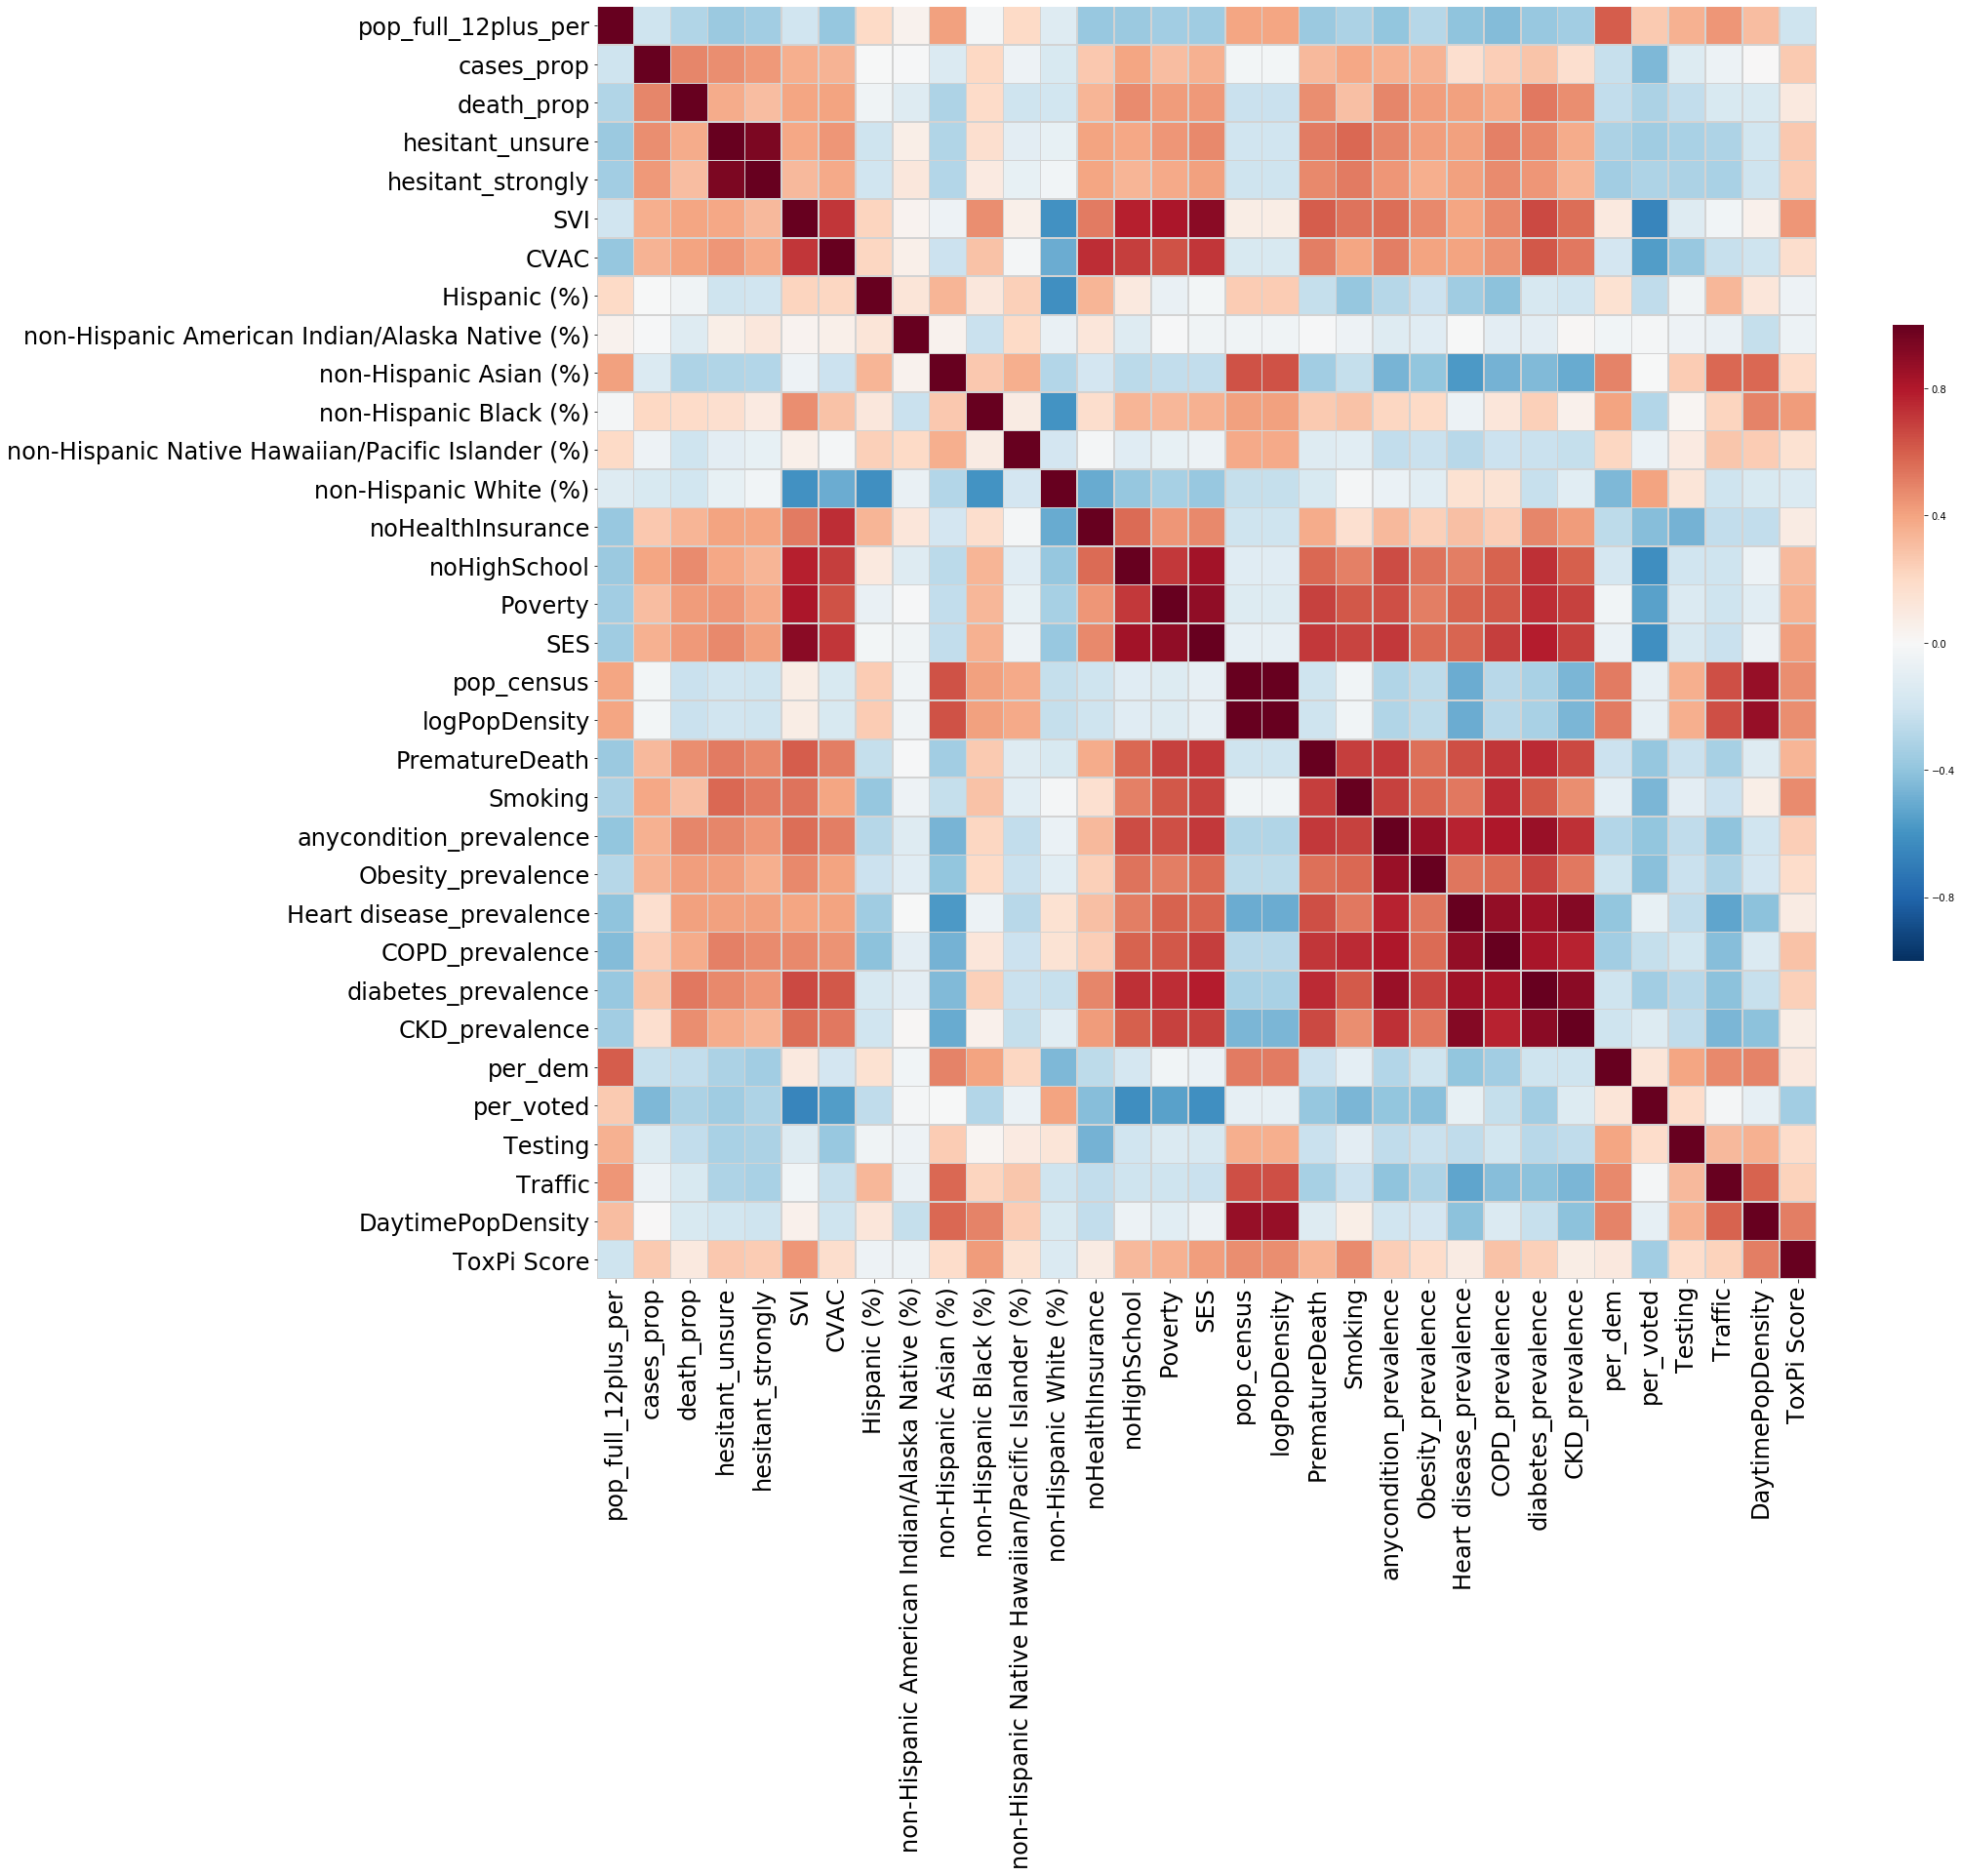

In [7]:
corr = df.select_dtypes(include = ['float64']).drop(columns = ['pop_full_18plus_per',
                               'pop_full_65plus_per', 'WBSeg', 'WNWSeg']).corr(method = 'spearman')

plt.figure(figsize = (28, 24))

color_map = plt.cm.get_cmap('RdBu')
reversed_col = color_map.reversed()

ax = sns.heatmap(corr, 
                      cmap = reversed_col, linewidths = 0.6,
                      cbar_kws={"shrink": 0.5},
                      vmin = -1, vmax = 1,
                      linecolor = 'lightgrey')
ax.tick_params(axis = 'both', which = 'major', labelsize = 24)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

-----------
## Drop `Alaska`:

In [8]:
df = df.drop(df.loc[df['state'] == 'Alaska'].index)

In [9]:
missing_cols = df.isnull().sum()[df.isnull().sum() > 0].index.tolist()
missing_cols

['pop_full_12plus_per',
 'pop_full_18plus_per',
 'pop_full_65plus_per',
 'cases_prop',
 'death_prop',
 'SVI',
 'SVI_cat',
 'SES',
 'PrematureDeath']

## Impute `SVI` , `SVI_cat` & `SES` 

One state in New Mexico	`Rio Arriba County`, given that is only one value missing for these features, we will use the average of counties in New Mexico.

In [10]:
#corr['SVI'][corr['SVI'].values > 0.4]
svi_corr = corr['SVI'][corr['SVI'].values > 0.4].index.tolist()

In [11]:
nm_imp = df[['SVI', 'SES','state']].groupby(['state']).mean()[df[['SVI', 'SES',
                                                         'state']].groupby(['state']).mean().index == 'New Mexico']
nm_imp

,SVI,SES
state,,
New Mexico,0.789062,0.717884


In [12]:
#df[df['SVI'].isnull()]
df['SVI'] = df['SVI'].fillna(0.789062)
df['SES'] = df['SES'].fillna(0.717884)

In [13]:
df[['SVI_cat','SVI']].groupby('SVI_cat').describe()

SVI                                               
                         count      mean       std  min   25%  50%   75%  max
SVI_cat                                                                      
High Vulnerability       623.0  0.699583  0.057910  0.6  0.65  0.7  0.75  0.8
Low Vulnerability        619.0  0.299628  0.058026  0.2  0.25  0.3  0.35  0.4
Moderate Vulnerability   616.0  0.499692  0.057606  0.4  0.45  0.5  0.55  0.6
Very High Vulnerability  623.0  0.899807  0.058179  0.8  0.85  0.9  0.95  1.0
Very Low Vulnerability   626.0  0.099744  0.057948  0.0  0.05  0.1  0.15  0.2

In [14]:
df['SVI_cat'] = df['SVI_cat'].fillna('High Vulnerability')

#### Change to numerical:

`svi_dict = {'Very Low Vulnerability': 0,
            'Low Vulnerability': 1,
           'Moderate Vulnerability': 2,
           'High Vulnerability': 3,
           'Very High Vulnerability' : 4}`

In [15]:
df.isnull().sum()[df.isnull().sum() > 1]

pop_full_12plus_per     52
pop_full_18plus_per    262
pop_full_65plus_per      8
cases_prop              24
death_prop              47
PrematureDeath          53
dtype: int64

In [16]:
missing_cols = df.isnull().sum()[df.isnull().sum() > 0].index.tolist()
missing_cols

['pop_full_12plus_per',
 'pop_full_18plus_per',
 'pop_full_65plus_per',
 'cases_prop',
 'death_prop',
 'PrematureDeath']

## Impute `cases_prop`,  `death_prop` & `PrematureDeath`:

Using RFR and features, correlated with the feature of interest.


### `cases_prop` 


In [17]:
cases_corr = corr['cases_prop'][abs(corr['cases_prop'].values) > 0.3].index.tolist()
cases_corr

['cases_prop',
 'death_prop',
 'hesitant_unsure',
 'hesitant_strongly',
 'SVI',
 'CVAC',
 'noHighSchool',
 'Poverty',
 'SES',
 'PrematureDeath',
 'Smoking',
 'anycondition_prevalence',
 'Obesity_prevalence',
 'per_voted']

In [18]:
cases_pred = list(set(cases_corr) - set(missing_cols))
len(cases_pred)

11

In [19]:
# drop observations with NaN, we want to predict:
df_imp = df.dropna(subset = ['cases_prop'])

y_train_imp = df_imp['cases_prop']
X_train_imp = df_imp[cases_pred]

X_train_imp.columns

Index(['Smoking', 'noHighSchool', 'CVAC', 'anycondition_prevalence', 'Poverty',
       'per_voted', 'hesitant_unsure', 'hesitant_strongly', 'SES',
       'Obesity_prevalence', 'SVI'],
      dtype='object')

RFR rho: 0.714
R2 score: 0.563
MAE: 1.878



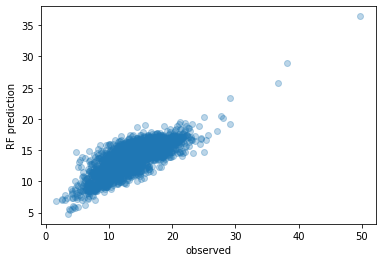

In [20]:
rf = RandomForestRegressor(random_state = 42, n_estimators = 100, max_features = 3, max_depth = 7)
rf.fit(X_train_imp, y_train_imp)
y_train_imp_pred = rf.predict(X_train_imp)

print('RFR rho: {:.3f}'.format(spearmanr(y_train_imp,y_train_imp_pred)[0]))
print('R2 score: {:.3f}'.format(r2_score(y_train_imp,y_train_imp_pred)))
print('MAE: {:.3f}'.format(mean_absolute_error(y_train_imp,y_train_imp_pred)))
print()
plt.scatter(y_train_imp,y_train_imp_pred, alpha = 0.3)
plt.xlabel('observed'), plt.ylabel('RF prediction')
plt.show()

In [21]:
for county in df['fips'].values:
    #print(county)
    
    if df[df['fips'] == county]['cases_prop'].isnull().values[0] == True:
        # select the features used for imputation:
        set2impute = df[df['fips'] == county][cases_pred]
        # predict cases using RF:
        county_cases_pred = rf.predict(set2impute)[0]
        # assign the predition:
        df.loc[df['fips'] == county, ['cases_prop']] = county_cases_pred
                                                  

### `death_prop` 


In [22]:
death_corr = corr['death_prop'][abs(corr['death_prop'].values) > 0.3].index.tolist()
death_corr

['cases_prop',
 'death_prop',
 'hesitant_unsure',
 'hesitant_strongly',
 'SVI',
 'CVAC',
 'non-Hispanic Asian (%)',
 'noHealthInsurance',
 'noHighSchool',
 'Poverty',
 'SES',
 'PrematureDeath',
 'Smoking',
 'anycondition_prevalence',
 'Obesity_prevalence',
 'Heart disease_prevalence',
 'COPD_prevalence',
 'diabetes_prevalence',
 'CKD_prevalence',
 'per_voted']

In [23]:
death_pred = list(set(death_corr) - set(missing_cols))
len(death_pred)

17

In [24]:
# drop observations with NaN, we want to predict:
df_imp = df.dropna(subset = ['death_prop'])

y_train_imp = df_imp['death_prop']
X_train_imp = df_imp[death_pred]

X_train_imp.columns

Index(['Smoking', 'noHighSchool', 'diabetes_prevalence', 'CVAC',
       'anycondition_prevalence', 'Poverty', 'Heart disease_prevalence',
       'noHealthInsurance', 'hesitant_unsure', 'per_voted',
       'non-Hispanic Asian (%)', 'hesitant_strongly', 'SES',
       'Obesity_prevalence', 'COPD_prevalence', 'CKD_prevalence', 'SVI'],
      dtype='object')

RFR rho: 0.748
R2 score: 0.550
MAE: 0.063



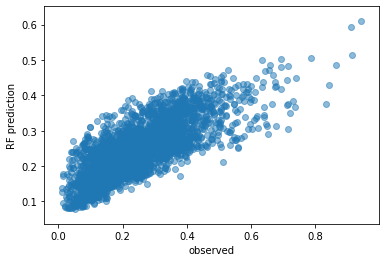

In [25]:
rf = RandomForestRegressor(random_state = 42, n_estimators = 100, max_features = 3, max_depth = 7)
rf.fit(X_train_imp, y_train_imp)
y_train_imp_pred = rf.predict(X_train_imp)

print('RFR rho: {:.3f}'.format(spearmanr(y_train_imp,y_train_imp_pred)[0]))
print('R2 score: {:.3f}'.format(r2_score(y_train_imp,y_train_imp_pred)))
print('MAE: {:.3f}'.format(mean_absolute_error(y_train_imp,y_train_imp_pred)))
print()
plt.scatter(y_train_imp,y_train_imp_pred, alpha = 0.5)
plt.xlabel('observed'), plt.ylabel('RF prediction')
plt.show()

In [26]:
for county in df['fips'].values:
    #print(county)
    
    if df[df['fips'] == county]['death_prop'].isnull().values[0] == True:
        # select the features used for imputation:
        set2impute = df[df['fips'] == county][death_pred]
        # predict cases using RF:
        county_cases_pred = rf.predict(set2impute)[0]
        # assign the predition:
        df.loc[df['fips'] == county, ['death_prop']] = county_cases_pred

In [27]:
df.isnull().sum()[df.isnull().sum() > 1]

pop_full_12plus_per     52
pop_full_18plus_per    262
pop_full_65plus_per      8
PrematureDeath          53
dtype: int64

### `PrematureDeath`

In [28]:
prem_corr = corr['PrematureDeath'][abs(corr['PrematureDeath'].values) > 0.3].index.tolist()
prem_corr.remove('pop_full_12plus_per')
prem_corr

['cases_prop',
 'death_prop',
 'hesitant_unsure',
 'hesitant_strongly',
 'SVI',
 'CVAC',
 'non-Hispanic Asian (%)',
 'noHealthInsurance',
 'noHighSchool',
 'Poverty',
 'SES',
 'PrematureDeath',
 'Smoking',
 'anycondition_prevalence',
 'Obesity_prevalence',
 'Heart disease_prevalence',
 'COPD_prevalence',
 'diabetes_prevalence',
 'CKD_prevalence',
 'per_voted',
 'Traffic',
 'ToxPi Score']

In [29]:
prem_pred = list(set(prem_corr) - set(missing_cols))
len(prem_pred)

19

In [30]:
# drop observations with NaN, we want to predict:
df_imp = df.dropna(subset = ['PrematureDeath'])

y_train_imp = df_imp['PrematureDeath']
X_train_imp = df_imp[prem_pred]

X_train_imp.columns

Index(['Smoking', 'noHighSchool', 'CVAC', 'diabetes_prevalence',
       'anycondition_prevalence', 'ToxPi Score', 'Poverty',
       'Heart disease_prevalence', 'noHealthInsurance', 'per_voted',
       'hesitant_unsure', 'non-Hispanic Asian (%)', 'hesitant_strongly',
       'Obesity_prevalence', 'SES', 'COPD_prevalence', 'CKD_prevalence', 'SVI',
       'Traffic'],
      dtype='object')

RFR rho: 0.871
R2 score: 0.757
MAE: 967.626



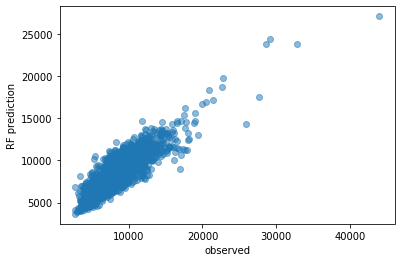

In [31]:
rf = RandomForestRegressor(random_state = 42, n_estimators = 100, max_features = 3, max_depth = 7)
rf.fit(X_train_imp, y_train_imp)
y_train_imp_pred = rf.predict(X_train_imp)

print('RFR rho: {:.3f}'.format(spearmanr(y_train_imp,y_train_imp_pred)[0]))
print('R2 score: {:.3f}'.format(r2_score(y_train_imp,y_train_imp_pred)))
print('MAE: {:.3f}'.format(mean_absolute_error(y_train_imp,y_train_imp_pred)))
print()
plt.scatter(y_train_imp,y_train_imp_pred, alpha = 0.5)
plt.xlabel('observed'), plt.ylabel('RF prediction')
plt.show()

In [32]:
for county in df['fips'].values:
    #print(county)
    
    if df[df['fips'] == county]['PrematureDeath'].isnull().values[0] == True:
        # select the features used for imputation:
        set2impute = df[df['fips'] == county][prem_pred]
        # predict cases using RF:
        county_cases_pred = rf.predict(set2impute)[0]
        # assign the predition:
        df.loc[df['fips'] == county, ['PrematureDeath']] = county_cases_pred

In [33]:
df.isnull().sum()[df.isnull().sum() > 1]

pop_full_12plus_per     52
pop_full_18plus_per    262
pop_full_65plus_per      8
dtype: int64

### Investigating outliers in target feature:

- `cases_prop` > 30
- `PrematureDeath` > 35500
- It is highly unlikely that these counties have 99.9% vaccinated `pop_full_12plus_per` - assign to NaN

In [34]:
df[df['cases_prop'] > 30]

,fips,state,county,state_abb,pop_full_12plus_per,pop_full_18plus_per,pop_full_65plus_per,cases_prop,death_prop,hesitant_unsure,...,Heart disease_prevalence,COPD_prevalence,diabetes_prevalence,CKD_prevalence,per_dem,per_voted,Testing,Traffic,DaytimePopDensity,ToxPi Score
257,8025,Colorado,Crowley County,CO,20.0,20.2,51.6,38.112523,0.329979,0.1484,...,7.2,7.3,11.2,3.2,0.249714,0.288731,8513.0,5.744853,5.0,0.499863
412,13053,Georgia,Chattahoochee County,GA,99.9,99.9,99.9,49.784542,0.155863,0.2319,...,3.5,4.5,6.7,1.8,0.421618,0.145044,440.0,33.168180,99.6,0.513570
2581,48127,Texas,Dimmit County,TX,69.7,NaN,74.1,36.675227,0.414856,0.1724,...,10.2,8.3,20.2,4.7,0.617567,0.362110,1847.0,181.034385,11.9,0.471849


In [35]:
df[df['PrematureDeath'] > 35500]

,fips,state,county,state_abb,pop_full_12plus_per,pop_full_18plus_per,pop_full_65plus_per,cases_prop,death_prop,hesitant_unsure,...,Heart disease_prevalence,COPD_prevalence,diabetes_prevalence,CKD_prevalence,per_dem,per_voted,Testing,Traffic,DaytimePopDensity,ToxPi Score
2912,51530,Virginia,Buena Vista city,VA,42.7,44.5,64.1,17.891324,0.339611,0.1359,...,9.4,10.8,13.3,3.7,0.29719,0.428527,2439.0,178.525612,821.6,0.589936


#### 3 counties have 99.9 for vaccination rate for all three groupings:

In [36]:
df[df['pop_full_12plus_per'] == 99.9]

,fips,state,county,state_abb,pop_full_12plus_per,pop_full_18plus_per,pop_full_65plus_per,cases_prop,death_prop,hesitant_unsure,...,Heart disease_prevalence,COPD_prevalence,diabetes_prevalence,CKD_prevalence,per_dem,per_voted,Testing,Traffic,DaytimePopDensity,ToxPi Score
108,4023,Arizona,Santa Cruz County,AZ,99.9,99.9,99.9,18.977160,0.408620,0.2230,...,8.6,7.3,16.0,4.4,0.671643,0.420685,1387.0,167.709624,38.9,0.397617
412,13053,Georgia,Chattahoochee County,GA,99.9,99.9,99.9,49.784542,0.155863,0.2319,...,3.5,4.5,6.7,1.8,0.421618,0.145044,440.0,33.168180,99.6,0.513570
1807,35031,New Mexico,McKinley County,NM,99.9,99.9,99.9,19.443160,0.694999,0.2343,...,9.9,11.6,18.4,4.8,0.680699,0.371124,2595.0,89.922099,13.3,0.426726


In [43]:
df[df['pop_full_18plus_per'] == 99.9]

,fips,state,county,state_abb,pop_full_12plus_per,pop_full_18plus_per,pop_full_65plus_per,cases_prop,death_prop,hesitant_unsure,...,Heart disease_prevalence,COPD_prevalence,diabetes_prevalence,CKD_prevalence,per_dem,per_voted,Testing,Traffic,DaytimePopDensity,ToxPi Score
108,4023,Arizona,Santa Cruz County,AZ,NaN,99.9,99.9,18.977160,0.408620,0.2230,...,8.6,7.3,16.0,4.4,0.671643,0.420685,1387.0,167.709624,38.9,0.397617
412,13053,Georgia,Chattahoochee County,GA,NaN,99.9,99.9,49.784542,0.155863,0.2319,...,3.5,4.5,6.7,1.8,0.421618,0.145044,440.0,33.168180,99.6,0.513570
1807,35031,New Mexico,McKinley County,NM,NaN,99.9,99.9,19.443160,0.694999,0.2343,...,9.9,11.6,18.4,4.8,0.680699,0.371124,2595.0,89.922099,13.3,0.426726
1943,37117,North Carolina,Martin County,NC,95.5,99.9,99.9,15.343137,0.271836,0.1881,...,10.4,10.8,18.2,4.5,0.471372,0.558824,3476.0,30.631705,48.9,0.457886


In [37]:
vacc_descr = df[['state','pop_full_12plus_per']].groupby('state').describe()
vacc_descr[df[['state','pop_full_12plus_per']].groupby('state').describe().index == 'Arizona']

pop_full_12plus_per                                                  \
                      count       mean        std   min    25%   50%    75%   
state                                                                         
Arizona                15.0  62.613333  16.792467  39.7  48.85  61.7  70.55   

               
          max  
state          
Arizona  99.9

In [38]:
vacc_descr[df[['state','pop_full_12plus_per']].groupby('state').describe().index == 'Georgia']

pop_full_12plus_per                                                 \
                      count       mean        std  min    25%   50%    75%   
state                                                                        
Georgia               159.0  24.258491  11.198662  8.1  15.75  21.9  29.45   

               
          max  
state          
Georgia  99.9

In [39]:
vacc_descr[df[['state','pop_full_12plus_per']].groupby('state').describe().index == 'New Mexico']

pop_full_12plus_per                                                \
                         count       mean        std   min   25%   50%   75%   
state                                                                          
New Mexico                33.0  53.690909  16.836166  24.8  41.3  50.7  66.4   

                  
             max  
state             
New Mexico  99.9

In [45]:
df.loc[df['pop_full_12plus_per'] == 99.9, ['pop_full_12plus_per']] = np.nan
df.loc[df['pop_full_18plus_per'] == 99.9, ['pop_full_18plus_per']] = np.nan

In [46]:
df.isnull().sum()[df.isnull().sum() > 1]

pop_full_12plus_per     55
pop_full_18plus_per    266
pop_full_65plus_per      8
dtype: int64

In [47]:
df.to_csv(dd + 'data_after_imputation.csv', index = False)